## Two-dimensional waveguide

Derivation and discussion in notes.

In [1]:
import fenics as fen
import mshr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
height = 5.0
width = 1.0
domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(height, width))
mesh = mshr.generate_mesh(domain, 64)
V = fen.FunctionSpace(mesh, 'P', 1)

In [3]:
class Walls(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (fen.near(x[1], 0) or fen.near(x[1], width))
    
class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0)
    
class Outlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], height)

In [4]:
v = fen.TestFunction(V)
A = fen.TrialFunction(V)

dx = fen.Measure('dx', domain=mesh)

mu = 1.0 # 4*np.pi*1e-7
eps = 1.0 # 8.85418782e-12

a_stiff = (1/mu) * fen.dot(fen.grad(A), fen.grad(v))*dx
a_mass = eps*A*v*dx
omega = 5
a = a_stiff - omega**2 * a_mass

# Technique seen at https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html
boundary = fen.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
inlet = Inlet()
inlet.mark(boundary, 1)
walls = Walls()
walls.mark(boundary, 2)
outlet = Outlet()
outlet.mark(boundary, 3)
ds = fen.Measure('ds', subdomain_data=boundary)

### Neumann boundary conditions imposed by a magnetic field B

0.14150033363202655

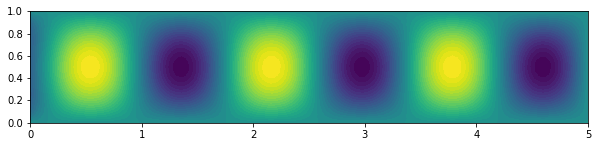

In [5]:
B_0 = 1.0
g_zro = fen.Constant(0.0)
g_cst = fen.Expression('-(1/mu)*B_0', degree=2, B_0=B_0, mu=mu)
g_exp = fen.Expression('-(1/mu)*B_0*exp(-pow(x[1] - width/2, 2) / 0.01)', degree=2, B_0=B_0, mu=mu, width=width)
L = g_cst*v*ds(1)# + g_zro*v*ds(1)
#L = g_exp*v*ds(1)# + g_zro*v*ds(2)
bc_walls = fen.DirichletBC(V, fen.Constant('0.0'), walls)
bc_outlet = fen.DirichletBC(V, fen.Constant('0.0'), outlet)
bcs = [bc_walls, bc_outlet]

A = fen.Function(V)
fen.solve(a == L, A, bcs)
plt.figure(figsize=(10, 3))
fen.plot(A)
np.mean(np.abs(A.compute_vertex_values(mesh)))

### Dirichlet boundary conditions imposed by electric field E
This is wrong, because I'm not yet sure how to deal with complex numbers. $E$ is thus in general phase-shifted below.

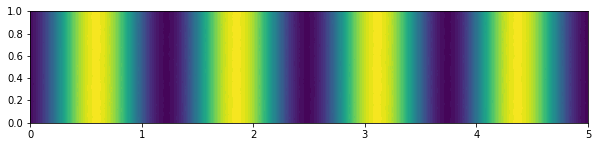

In [6]:
E_0 = 1.0
E_zro = fen.Constant(0.0)
E_cst = fen.Expression('-(1/omega)*E_0', degree=2, E_0=E_0, omega=omega)
E_exp = fen.Expression('-(1/omega)*E_0*exp(-pow(x[1] - width/2, 2) / 0.01)', degree=2, E_0=E_0, omega=omega, width=width)
#E_cpl = fen.Expression('(i/omega)*E_0', degree=2, E_0=E_0, omega=omega)
L = fen.Constant(0.0)*v*dx
bc = fen.DirichletBC(V, E_cst , Inlet())
#bc = fen.DirichletBC(V, E_zro, Walls())

A = fen.Function(V)
fen.solve(a == L, A, bc)
plt.figure(figsize=(10, 3))
fen.plot(A)